# Dota API match data EDA

This script covers the initial data exploration for feature extraction as well as tests for the engineering of the data preprocessing pipeline.

## Setup

### Imports

In [22]:
import requests
import pprint
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import game_data_collector.parse_game_data_utils as pgdu
import game_data_collector.api as dapi
from database import MongoDB


### Get Heroes from OpenDota API (real time)

**With Explorer API (alternatively)**  
Note: Uses PostgreSQL 9.5.10: SELECT version();  

Get heroes table columns and types:  
`SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'heroes';`  

Get all heroes:  
`SELECT * from heroes ORDER by heroes.id ASC;`

#### All heroes

In [2]:
res: requests.Response = pgdu.make_request_with_retries("https://api.opendota.com/api/heroes")
heroes: list[dict] = []
if res.status_code != 200:
    raise ValueError(f'Failed to retrieve data: {res.status_code}')
else:
    heroes = json.loads(res.text)

# print(heroes)

In [3]:
heroes_ids_roles = pd.DataFrame(heroes, columns=["id", "localized_name", "attack_type"]).set_index('id', drop=True) # 145 heroes in total
print(heroes_ids_roles)

     localized_name attack_type
id                             
1         Anti-Mage       Melee
2               Axe       Melee
3              Bane      Ranged
4       Bloodseeker       Melee
5    Crystal Maiden      Ranged
..              ...         ...
135     Dawnbreaker       Melee
136           Marci       Melee
137    Primal Beast       Melee
138          Muerta      Ranged
145             Kez       Melee

[126 rows x 2 columns]


#### Filter by role

Distinct roles are: Carry, Durable, Escape, Initiator, Disabler, Nuker, Support, Pusher (heroes can have multiple roles!)  
`SELECT DISTINCT roles from heroes;`  

Get all heroes that are flagged as 'Carry':  
`SELECT * from heroes WHERE 'Carry' = ANY(roles) ORDER by heroes.id ASC;`

Role.CANONICAL_CARRY is a custom set of predefined heroes

In [4]:
# Sample call
print(dapi.get_hero_ids_of_role(dapi.Role.CANONICAL_CARRY))

[1, 4, 6, 8, 12, 18, 41, 44, 46, 48, 54, 56, 59, 61, 67, 72, 77, 80, 81, 94, 109]


### DB Connection (to cached match data)

In [5]:
db = MongoDB(username='root', password='example')
db.connect_db()
db.get_database("mmr_predictor")
col = db.get_collection("dota_game_collection")

## Database queries (MongoDB)

In [ ]:
# Sample document structure

res = col.find_one()
# pprint.pprint(res)

### Unique matches and players

In [7]:
print(f"Found {col.count_documents({})} recorded matches with {len(col.distinct('players.account_id'))} unique players in the database.")

# First batch has 5180 matches and 20799 unique players of whom 18356 are in tier (11, 80)


Found 8954 recorded matches with 37319 unique players in the database.


### Match duration

In [8]:
# Query basic match duration statistics within mongo itself (a pipeline)

# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "mean": { "$avg": "$duration" },
            "min": { "$min": "$duration" },
            "max": { "$max": "$duration" },
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    },
    {
        "$addFields": {
            "std": { #
                "$sqrt": {
                    "$avg": {
                        "$map": {   # sum?
                            "input": "$durations",
                            "as": "duration",
                            "in": {
                                "$pow": [{ "$subtract": ["$$duration", "$mean"] }, 2] # (x_i - x_avg))**2
                            }
                        }
                    }
                }
            }
        }
    },
    {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "min": 1,
            "max": 1,
            "mean": 1,
            "std": 1
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))

if result:
    print(f"Match duration min={result[0]['min']/60:.1f} min, max={result[0]['max']/60:.1f} min, avg={result[0]['mean']/60:.1f} min, std={result[0]['std']/60:.1f} min")

Match duration min=25.0 min, max=66.0 min, avg=30.7 min, std=4.1 min


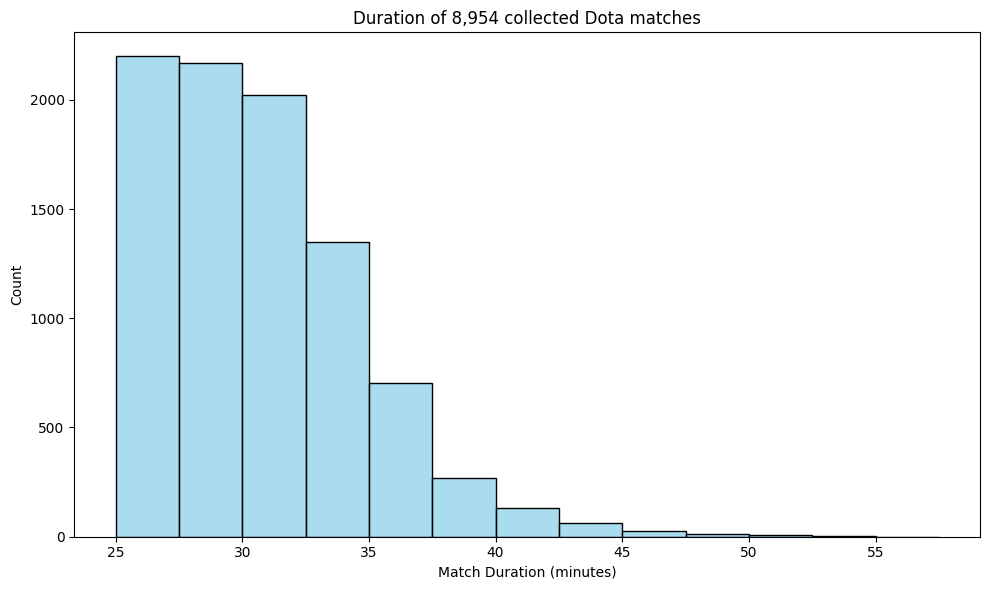

In [9]:
# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))
t_min = np.array(result[0]["durations"]) / 60

# Create the histogram
plt.figure(figsize=(10, 6))

# Set the style using seaborn
# sns.set_theme(style="whitegrid")

# IMPORTANT match duration cut of is set to 25 mins in game_data_collector.validate_clean_match_data
# Define bin edges for 2.5-minute intervals from 25 to 60
bins = np.arange(25, 60, 2.5)  

# Plot histogram using sns.histplot
sns.histplot(
    t_min,
    bins=bins,
    kde=False,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

# Customize x-ticks to show every 5 minutes
plt.xticks(np.arange(25, 60, 5))

# Labeling x and y axis, and title
plt.xlabel('Match Duration (minutes)')
plt.ylabel('Count')
plt.title(f'Duration of {len(t_min):,} collected Dota matches')

# Enhance layout
plt.tight_layout()

# Show the plot
plt.show()


### Players Rank Tiers

#### Distinct tiers

In [10]:
# There are 5*8 Dota 2 MMR ranks: https://dota2freaks.com/ranks/
# There are 8 different tiers, with 5 levels each: Herald, Guardian, Crusader, Archon, Legend, Ancient Divine Immortal
# I think this explains the data showing (None-10) 11-15, 21-25, 31-35 etc

# IMPORTANT: Immortal (Rank 8) is "placed", and contains Top 1 to 1000 players (huge bin)

distinct_tiers = col.distinct("players.rank_tier")
print(f"Found {len(distinct_tiers)} different rank tiers: {distinct_tiers}")

Found 36 different rank tiers: [None, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55, 61, 62, 63, 64, 65, 71, 72, 73, 74, 75, 80]


#### Rank tiers of players

In [12]:
# get all players excluding ranks min (None) and max (80)
rank_tiers: list[int] = []

pipeline = [
    {"$unwind": "$players"}, # Unwind the players array
    {"$match": {"players.rank_tier": {"$nin": [None, 80]}}},         # Match only documents where rank_tier is not min or max
    {"$group": {"_id": None, "rank_tiers": {"$push": "$players.rank_tier"}}}, # Collect all player ranks (including duplicates)
    {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
]

# just replacing None with 0
# pipeline = [
#     {"$unwind": "$players"}, # Unwind the players array
#     {"$group": {"_id": None, "rank_tiers": {"$push": {"$ifNull": ["$players.rank_tier", 0]}}}},  # replace None by 0
#     {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
# ]

res = col.aggregate(pipeline)

for r in res:   # assuming there is only one result entry
    rank_tiers = r['rank_tiers']
    
print(f"{len(rank_tiers):,} of {len(col.distinct('players.account_id')):,} recorded players ({(len(rank_tiers)/len(col.distinct('players.account_id')))*100:.1f} %) are in Ranks 12 - 75")

32,699 of 37,319 recorded players (87.6 %) are in Ranks 12 - 75


[11, 21, 31, 41, 51, 61, 71, 81]


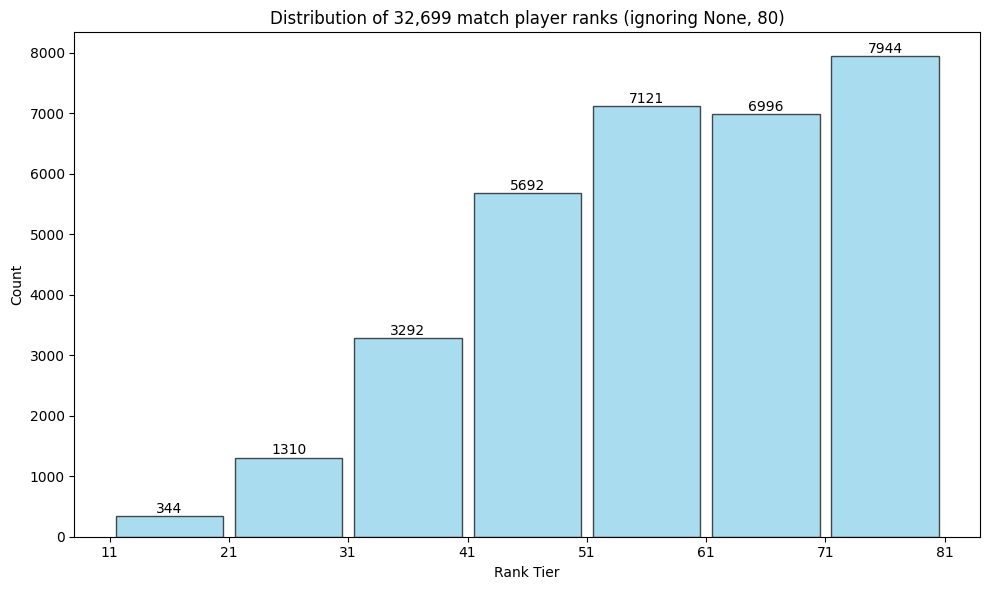

In [13]:
# Create the histogram
plt.figure(figsize=(10, 6))
bins = range(11, 91, 10)  # Bins from 0 to 80 with a width of 10
print(list(bins))

bar_width = 0.9 * (bins[1] - bins[0]) 

# Plot histogram
counts, _, patches = plt.hist(rank_tiers, bins=bins, density=False, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.9)

# Labeling x and y axis, and title
plt.xlabel('Rank Tier')
plt.ylabel('Count',)
plt.title(f'Distribution of {len(rank_tiers):,} match player ranks (ignoring None, 80)')

# Set x-ticks at intervals of 10
plt.xticks(range(11, 91, 10))

# Display counts on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{int(count)}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Match Feature Exploration

Currently supported KPIs are

|KPI|attr|description|supplemental|
|---|---|---|---|
|kda|kda|kill-death-assist-ratio $\frac{k+a}{d}$|[reddit](https://www.reddit.com/r/DotA2/comments/20dnc8/what_is_a_good_kda_ratio/)|
|last hit|last_hit|get final hit of a creep, hero or building||
|apm|actions_per_min|avg. control input count of player|[reddit](https://www.reddit.com/r/learndota2/comments/6f0n5a/can_somebody_explain_actions_per_minute_to_me/)|
|gpm|gold_per_min|depends on factors like match duration and last hit count of buildings|[reddit](https://www.reddit.com/r/DotA2/comments/srgpw/whats_an_average_gold_per_minute/)|
|xpm|xp_per_min|hero xp gained per match, kill xp is shared between all allies in a defined radius|[dota2 fandom](https://dota2.fandom.com/wiki/Experience)|


#### Summarizing

In [14]:
# KPI stats of all players
df_all = dapi.get_kpis_by_role(col, dapi.Role.ANY, rank_nin=None).drop(columns = "hero_id") # ALL the players
print(df_all.describe())

          rank_tier           kda     last_hits  actions_per_min  \
count  89540.000000  89540.000000  89540.000000     89540.000000   
mean      31.972660      3.944431    132.167043       230.504344   
std       33.341745      4.508051     89.596349        94.391160   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      1.140000     52.000000       147.000000   
50%       25.000000      2.400000    123.000000       226.000000   
75%       65.000000      5.140000    192.000000       304.000000   
max       80.000000     54.000000    702.000000       824.000000   

       gold_per_min    xp_per_min  
count  89540.000000  89540.000000  
mean     456.042685    556.842864  
std      153.482372    187.604907  
min      108.000000      5.000000  
25%      343.000000    420.000000  
50%      430.000000    535.000000  
75%      559.000000    669.000000  
max     2014.000000   1930.000000  


#### Explorative PCA Analysis

In [32]:
print(df_all.head())
print(df_all.shape)

# normalize features because of different data scale
# drop rank tier at it is our target variable
df_all_norm_vals = StandardScaler().fit_transform(df_all.drop(columns="rank_tier"))
print(f"normalized mean = {np.mean(df_all_norm_vals)}, std = {np.std(df_all_norm_vals)}")
print()

df_all_norm = pd.DataFrame(df_all_norm_vals, columns=df_all.columns[1:])
print(df_all_norm.head())
print(df_all_norm.shape)


   rank_tier    kda  last_hits  actions_per_min  gold_per_min  xp_per_min
0         55   3.29         21              130           382         463
1          0   8.50        245              459           724         765
2          0   4.00        106              153           605         566
3          0  25.00         28              327           378         518
4         61   4.00        152              334           536         575
(89540, 6)
normalized mean = 9.297206491138412e-17, std = 1.0

        kda  last_hits  actions_per_min  gold_per_min  xp_per_min
0 -0.145170  -1.240761        -1.064770     -0.482421   -0.500218
1  1.010546   1.259355         2.420745      1.745860    1.109557
2  0.012327  -0.292056        -0.821102      0.970523    0.048811
3  4.670685  -1.162632         1.022301     -0.508483   -0.207047
4  0.012327   0.221360         1.096461      0.520957    0.096784
(89540, 5)


In [37]:
pca = PCA(n_components=len(df_all_norm.columns))
pc_all_kpis_vals = pca.fit_transform(df_all_norm_vals)

pc_all_kpis = pd.DataFrame(pc_all_kpis_vals, columns=[f"PC{n}" for n in range(1, pc_all_kpis_vals.shape[1]+1)])
print(pc_all_kpis.head())
print(pc_all_kpis.shape)

        PC1       PC2       PC3       PC4       PC5
0 -1.398663 -0.734433  0.636713  0.446233  0.277613
1  3.005420  1.885818 -0.161028 -0.180069  0.314828
2  0.276923 -0.858075  0.198994  0.290261  0.875857
3  0.845665  1.500877  4.515275 -0.887433 -0.608693
4  0.666926  0.966030 -0.270381 -0.018108  0.284087
(89540, 5)


In [ ]:
# PVE
print('Proportion of Variability Explained per PC: {}'.format(pca.explained_variance_ratio_))

Explained variability per principal component: [0.58779976 0.18575224 0.16388963 0.04527614 0.01728223]


In [ ]:
ranks = sorted(df_all["rank_tier"].unique())
print(len(ranks))
colors = sns.color_palette('Set2', n_colors=len(df_all["rank_tier"].unique()))

for rank, color in zip(ranks,colors):
    print(rank, color)

C:\Users\cedri\AppData\Local\Temp\ipykernel_15924\2278635488.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pc_all_kpis.loc[indicesToKeep, 'PC1']


<Figure size 640x480 with 0 Axes>

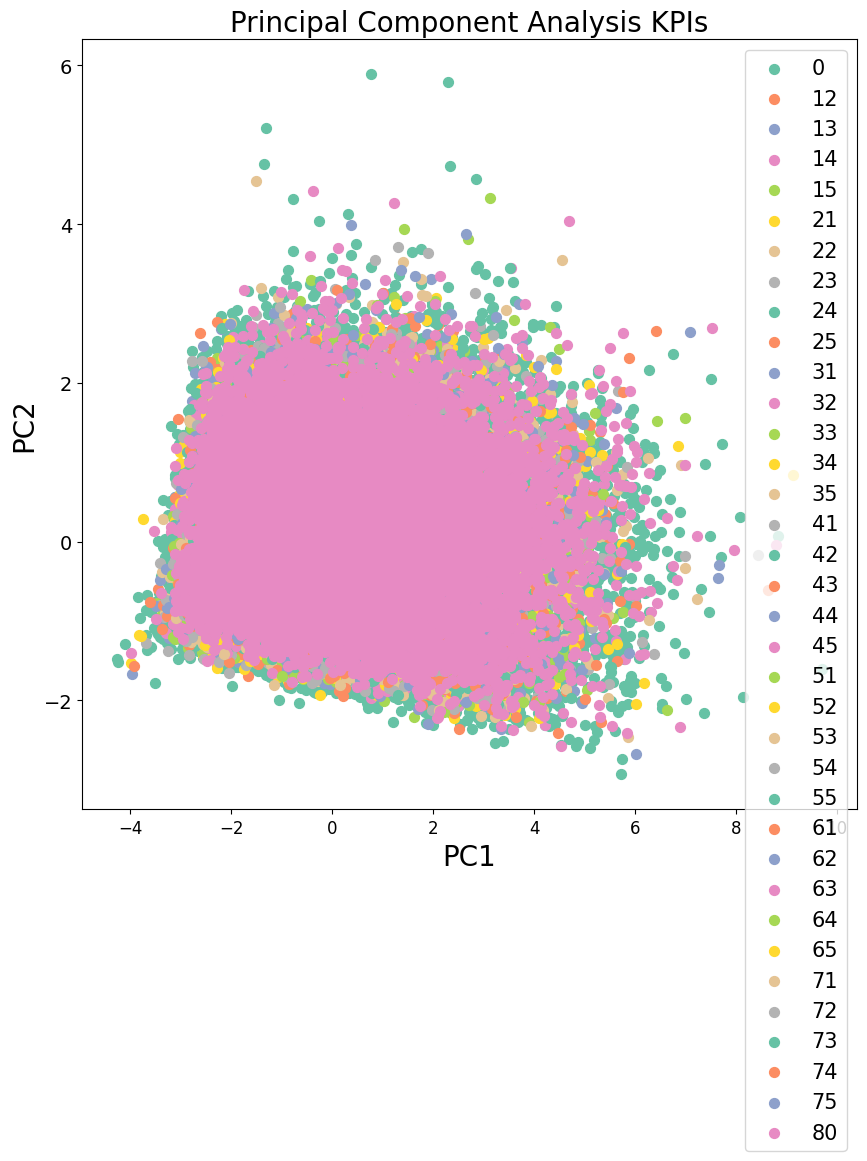

In [50]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.title("Principal Component Analysis KPIs",fontsize=20)
ranks = sorted(df_all["rank_tier"].unique())
colors = sns.color_palette('Set2', n_colors=len(df_all["rank_tier"].unique()))
for rank, color in zip(ranks,colors):
    indicesToKeep = df_all['rank_tier'] == rank
    plt.scatter(pc_all_kpis.loc[indicesToKeep, 'PC1']
               , pc_all_kpis.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(ranks,prop={'size': 15})

#### KPI correlation matrix

In [15]:
# This is without rank tiers 0 and 80 !
df_any = dapi.get_kpis_by_role(col, dapi.Role.ANY)
df_cc = dapi.get_kpis_by_role(col, dapi.Role.CANONICAL_CARRY)

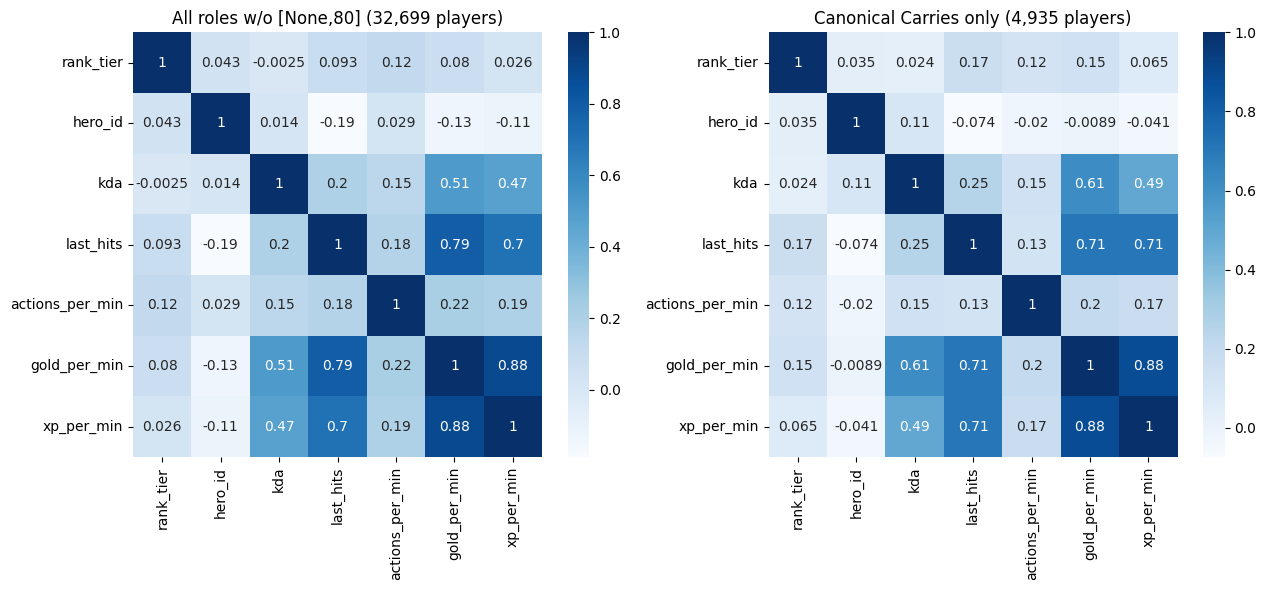

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Compute correlation matrix for df1 and plot it on the first subplot
matrix1 = df_any.corr()
sns.heatmap(matrix1, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title(f'All roles w/o [None,80] ({len(df_any):,} players)')

# Compute correlation matrix for df2 and plot it on the second subplot
matrix2 = df_cc.corr()
sns.heatmap(matrix2, annot=True, cmap='Blues', ax=axes[1])
axes[1].set_title(f'Canonical Carries only ({len(df_cc):,} players)')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

#### KPIs by hero role

In [ ]:
# get stats summary for each role
# CAVE: One hero can have multiple roles

all_stats_mean: list[pd.Series] = []

for role in tqdm(dapi.Role):
    
    # skip
    if role == dapi.Role.ANY:
        continue
    
    df_ = dapi.get_kpis_by_role(col, role)
    df_.drop("hero_id", axis=1, inplace=True)
    role_mean = df_.mean().round(2) # get mean of all kpis
    role_mean = pd.concat([role_mean, pd.Series({"count": len(df_)})]) # add sample count
    all_stats_mean.append(role_mean.rename(role.name))
    
df_stats_mean: pd.DataFrame = pd.DataFrame(all_stats_mean)

# MEAN !
print(df_stats_mean)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

                 rank_tier   kda  last_hits  actions_per_min  gold_per_min  \
CARRY                54.67  4.41     172.48           236.69        510.12   
DISABLER             54.66  3.95     117.74           226.19        435.16   
DURABLE              54.67  4.24     141.76           233.66        470.07   
ESCAPE               55.36  4.20     142.10           239.10        466.79   
INITIATOR            54.55  3.80     117.68           226.61        436.37   
NUKER                54.93  3.98     120.96           227.75        442.16   
PUSHER               54.50  4.02     159.42           231.64        485.88   
SUPPORT              54.24  3.77      83.56           216.17        389.31   
CANONICAL_CARRY      54.06  4.40     218.26           239.85        555.06   

                 xp_per_min    count  
CARRY                608.56  18708.0  
DISABLER             536.62  23981.0  
DURABLE              565.75  11991.0  
ESCAPE               573.99  12889.0  
INITIATOR            537

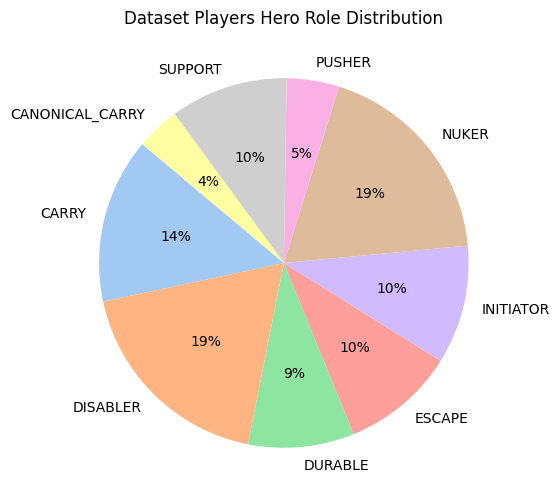

In [18]:
plt.figure(figsize=(10, 6)) 
colors = sns.color_palette('pastel')[0:len(df_stats_mean.index)]
plt.pie(df_stats_mean["count"], labels=df_stats_mean.index, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title("Dataset Players Hero Role Distribution") 
# plt.legend(title="Classes") 

plt.show()

In [ ]:
variables = ["kda", "last_hits", "actions_per_min", "gold_per_min", "xp_per_min"]

for var in variables:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.barplot(x=df_stats_mean.index, y=df_stats_mean[var], ax=ax, hue=df_stats_mean.index)
    ax.set_title(f"KPI '{var}' mean of dataset")
    ax.set_xlabel('Hero Role')
    ax.set_ylabel(var)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()